In [1]:
import sys
import os
from pathlib import Path

pwd  = Path(os.getcwd())
sys.path.append(str(pwd.parent.parent)) # needed to use "koray" module

In [2]:
import pandas as pd
import numpy as np

In [3]:
from koray.feature_calculation.util import get_features

conference_invitations = [
# 'NeurIPS.cc/2022/Conference/-/Blind_Submission',
'ICLR.cc/2023/Conference/-/Blind_Submission',
# 'ICLR.cc/2022/Conference/-/Blind_Submission',
# 'ICLR.cc/2021/Conference/-/Blind_Submission',
]

# feature_df = list(get_features(conference_invitations, disable_cache=True))
feature_df = list(get_features(conference_invitations, disable_cache=False))
df = pd.concat(feature_df)
df


✔ Successfully calculated features


,paper_id,abstract_length,author_count,conference_name,conference_year,individual_confidence_scores,individual_recommendation_scores,is_accepted,keyword_count,metareview_length,...,sentiment_analysis_score_negative_mean,sentiment_analysis_score_negative_var,sentiment_analysis_score_neutral_mean,sentiment_analysis_score_neutral_var,sentiment_analysis_score_positive_mean,sentiment_analysis_score_positive_var,sentiment_analysis_scores,title_length,tldr_length,web_url
0,-0tPmzgXS5,1197.0,5.0,ICLR.cc,2023,"[4, 4, 4]","[6, 5, 6]",False,3.0,NaN,...,0.065333,0.000033,0.803000,0.000561,0.131667,0.000864,"[{'neg': 0.058, 'neu': 0.774, 'pos': 0.168, 'c...",46.0,131.0,https://openreview.net/forum?id=-0tPmzgXS5
1,-1x2-lp1eZf,1862.0,7.0,ICLR.cc,2023,"[4, 4, 4, 4, 5]","[6, 3, 3, 3, 3]",False,3.0,NaN,...,0.048200,0.000516,0.829600,0.001903,0.122200,0.001342,"[{'neg': 0.025, 'neu': 0.904, 'pos': 0.071, 'c...",74.0,114.0,https://openreview.net/forum?id=-1x2-lp1eZf
2,-2zfgNS917,1497.0,6.0,ICLR.cc,2023,"[3, 4, 3, 4]","[6, 6, 8, 6]",True,3.0,NaN,...,0.030250,0.000387,0.838500,0.000178,0.131250,0.000812,"[{'neg': 0.036, 'neu': 0.841, 'pos': 0.123, 'c...",75.0,97.0,https://openreview.net/forum?id=-2zfgNS917
3,-4DiyBMgv9m,1246.0,2.0,ICLR.cc,2023,"[4, 3, 2, 3, 3]","[1, 6, 6, 3, 3]",False,0.0,NaN,...,0.048800,0.000333,0.885400,0.000269,0.065600,0.000207,"[{'neg': 0.085, 'neu': 0.862, 'pos': 0.053, 'c...",89.0,0.0,https://openreview.net/forum?id=-4DiyBMgv9m
4,-4Maz7s3YXz,1366.0,2.0,ICLR.cc,2023,"[4, 4, 4]","[3, 3, 5]",False,5.0,NaN,...,0.097000,0.000008,0.778667,0.000356,0.124333,0.000258,"[{'neg': 0.095, 'neu': 0.793, 'pos': 0.112, 'c...",65.0,125.0,https://openreview.net/forum?id=-4Maz7s3YXz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,zufPou5foW,1393.0,5.0,ICLR.cc,2023,"[4, 3, 4, 4]","[3, 3, 3, 6]",False,4.0,NaN,...,0.083500,0.000785,0.781250,0.001331,0.135250,0.000316,"[{'neg': 0.092, 'neu': 0.744, 'pos': 0.164, 'c...",82.0,0.0,https://openreview.net/forum?id=zufPou5foW
3792,zyLVMgsZ0U_,1107.0,6.0,ICLR.cc,2023,"[4, 3, 3, 3]","[8, 8, 8, 8]",True,6.0,NaN,...,0.040250,0.000195,0.836750,0.000432,0.123000,0.000931,"[{'neg': 0.063, 'neu': 0.859, 'pos': 0.078, 'c...",100.0,205.0,https://openreview.net/forum?id=zyLVMgsZ0U_
3793,zyfEWkV6it,1157.0,5.0,ICLR.cc,2023,"[4, 5, 5, 5, 3, 2]","[5, 6, 3, 3, 5, 6]",False,3.0,NaN,...,0.055167,0.001527,0.831500,0.001038,0.113333,0.000563,"[{'neg': 0.068, 'neu': 0.815, 'pos': 0.117, 'c...",45.0,0.0,https://openreview.net/forum?id=zyfEWkV6it
3794,zzL_5WoI3I,965.0,2.0,ICLR.cc,2023,"[4, 4, 3]","[3, 8, 6]",False,3.0,NaN,...,0.034000,0.000152,0.817333,0.001078,0.148667,0.001272,"[{'neg': 0.05, 'neu': 0.838, 'pos': 0.112, 'co...",83.0,208.0,https://openreview.net/forum?id=zzL_5WoI3I


In [4]:
df.dtypes

paper_id                                  object
abstract_length                          float64
author_count                             float64
conference_name                           object
conference_year                            int64
                                          ...   
sentiment_analysis_score_positive_var    float64
sentiment_analysis_scores                 object
title_length                             float64
tldr_length                              float64
web_url                                   object
Length: 86, dtype: object

In [5]:
# columns that have numerical values
numerical_columns = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]

/Users/koray/data-literacy-group16/koray/.venv/lib/python3.13/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


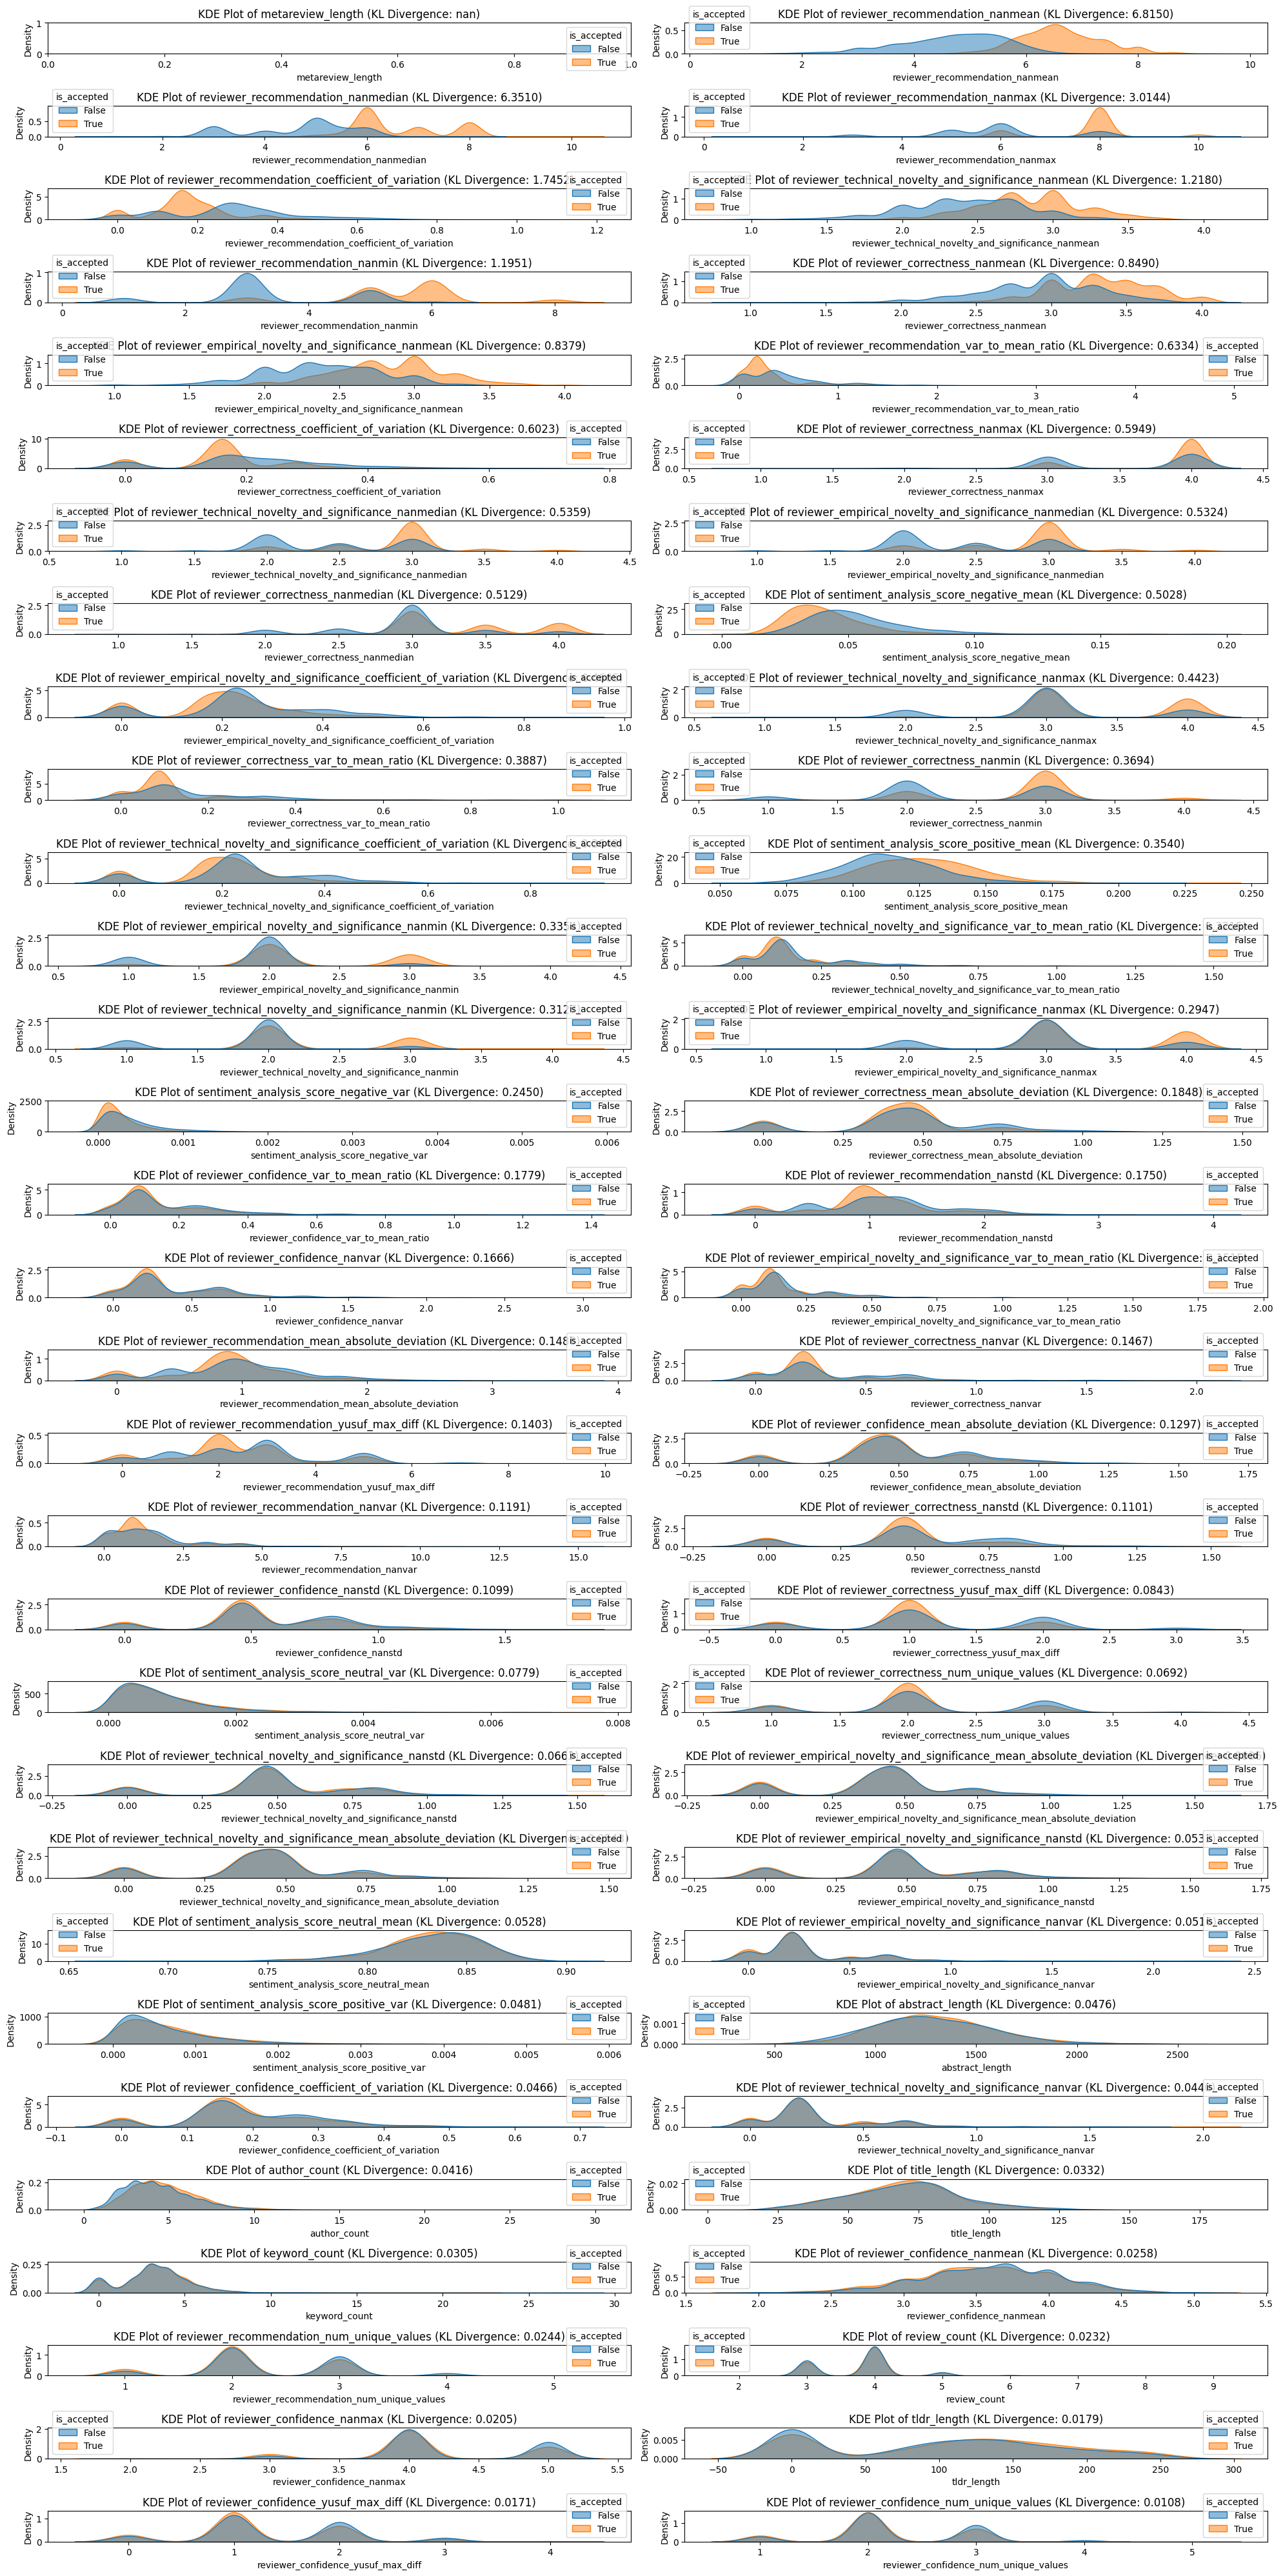

In [6]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy

# Calculate KL divergence
def calculate_kl_divergence(df, column, group_col='is_accepted'):
    group_0 = df[df[group_col] == 0][column].dropna()
    group_1 = df[df[group_col] == 1][column].dropna()
    
    # Calculate histograms for each group
    p, bins = np.histogram(group_0, bins=30, density=True)
    q, _ = np.histogram(group_1, bins=bins, density=True)
    
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    
    # Normalize to ensure they are probabilities
    p = p / p.sum()
    q = q / q.sum()
    
    # Calculate KL divergence
    return entropy(p, q)

# Compute KL divergence for all numerical columns
kl_divergences = {
    col: calculate_kl_divergence(df, col, group_col='is_accepted')
    for col in numerical_columns
}

# Sort numerical columns by KL divergence in descending order
sorted_columns = sorted(kl_divergences, key=kl_divergences.get, reverse=True)
# sorted_columns = sorted_columns[:32]
sorted_columns = sorted_columns[:62] # matplotlib can't handle more than 62 subplots

plt.figure(figsize=(20, 40))
for i, col in enumerate(sorted_columns, 1):
    plt.subplot(len(sorted_columns) // 2, 2, i)
    sns.kdeplot(data=df, x=col, hue='is_accepted', fill=True, common_norm=False, alpha=0.5)
    plt.title(f'KDE Plot of {col} (KL Divergence: {kl_divergences[col]:.4f})')

plt.tight_layout()
plt.show()


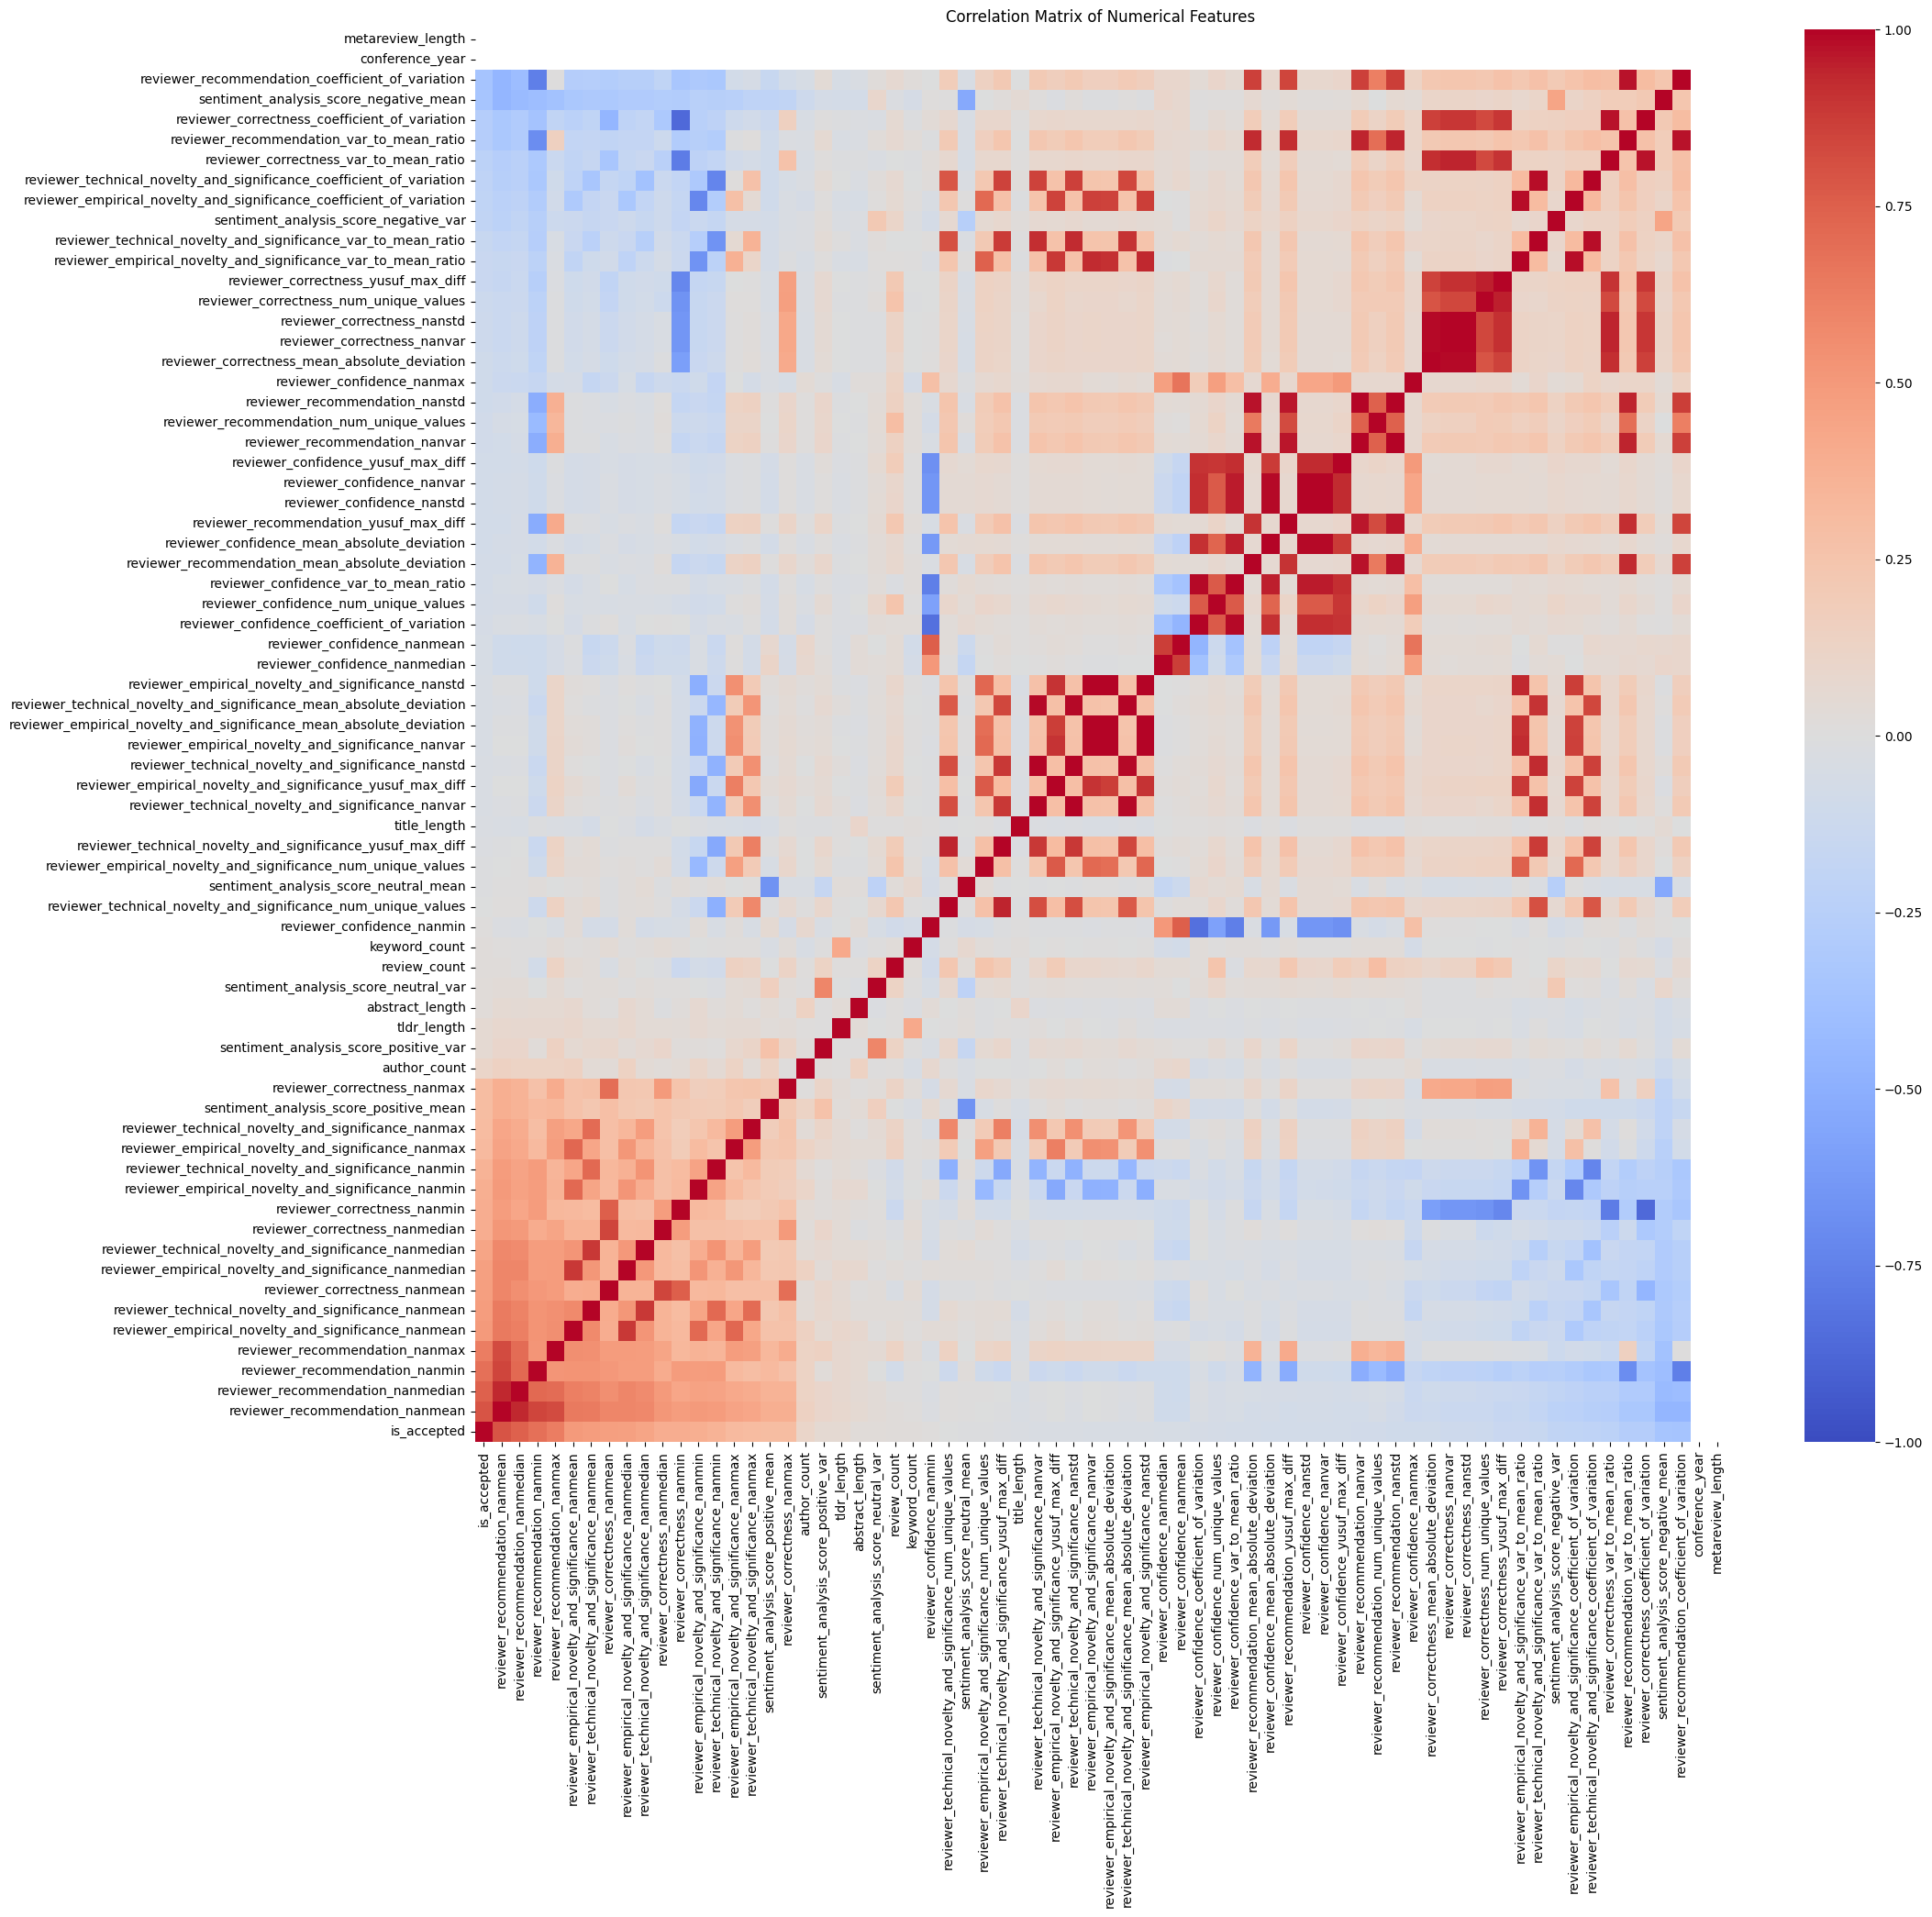

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pointbiserialr

# correlation_matrix = df.corr(numeric_only=True, method='pearson')
correlation_matrix = df.corr(numeric_only=True, method='spearman')
# correlation_matrix = df.corr(numeric_only=True, method=lambda x,y : pointbiserialr(x,y)[0])

# sort them based on correlation with the is_accepted column
idx = (correlation_matrix['is_accepted'] + 1).abs().sort_values(ascending=False).index
sorted_corr_matrix = correlation_matrix.loc[idx, idx]


# Plot the correlation matrix using a heatmap
plt.figure(figsize=(22, 20))
ax = sns.heatmap(sorted_corr_matrix, annot=False, fmt='.01f', cmap='coolwarm', cbar=True,  vmin=-1, vmax=1)

# Flip the y-axis
ax.invert_yaxis()

plt.title("Correlation Matrix of Numerical Features")
plt.show()

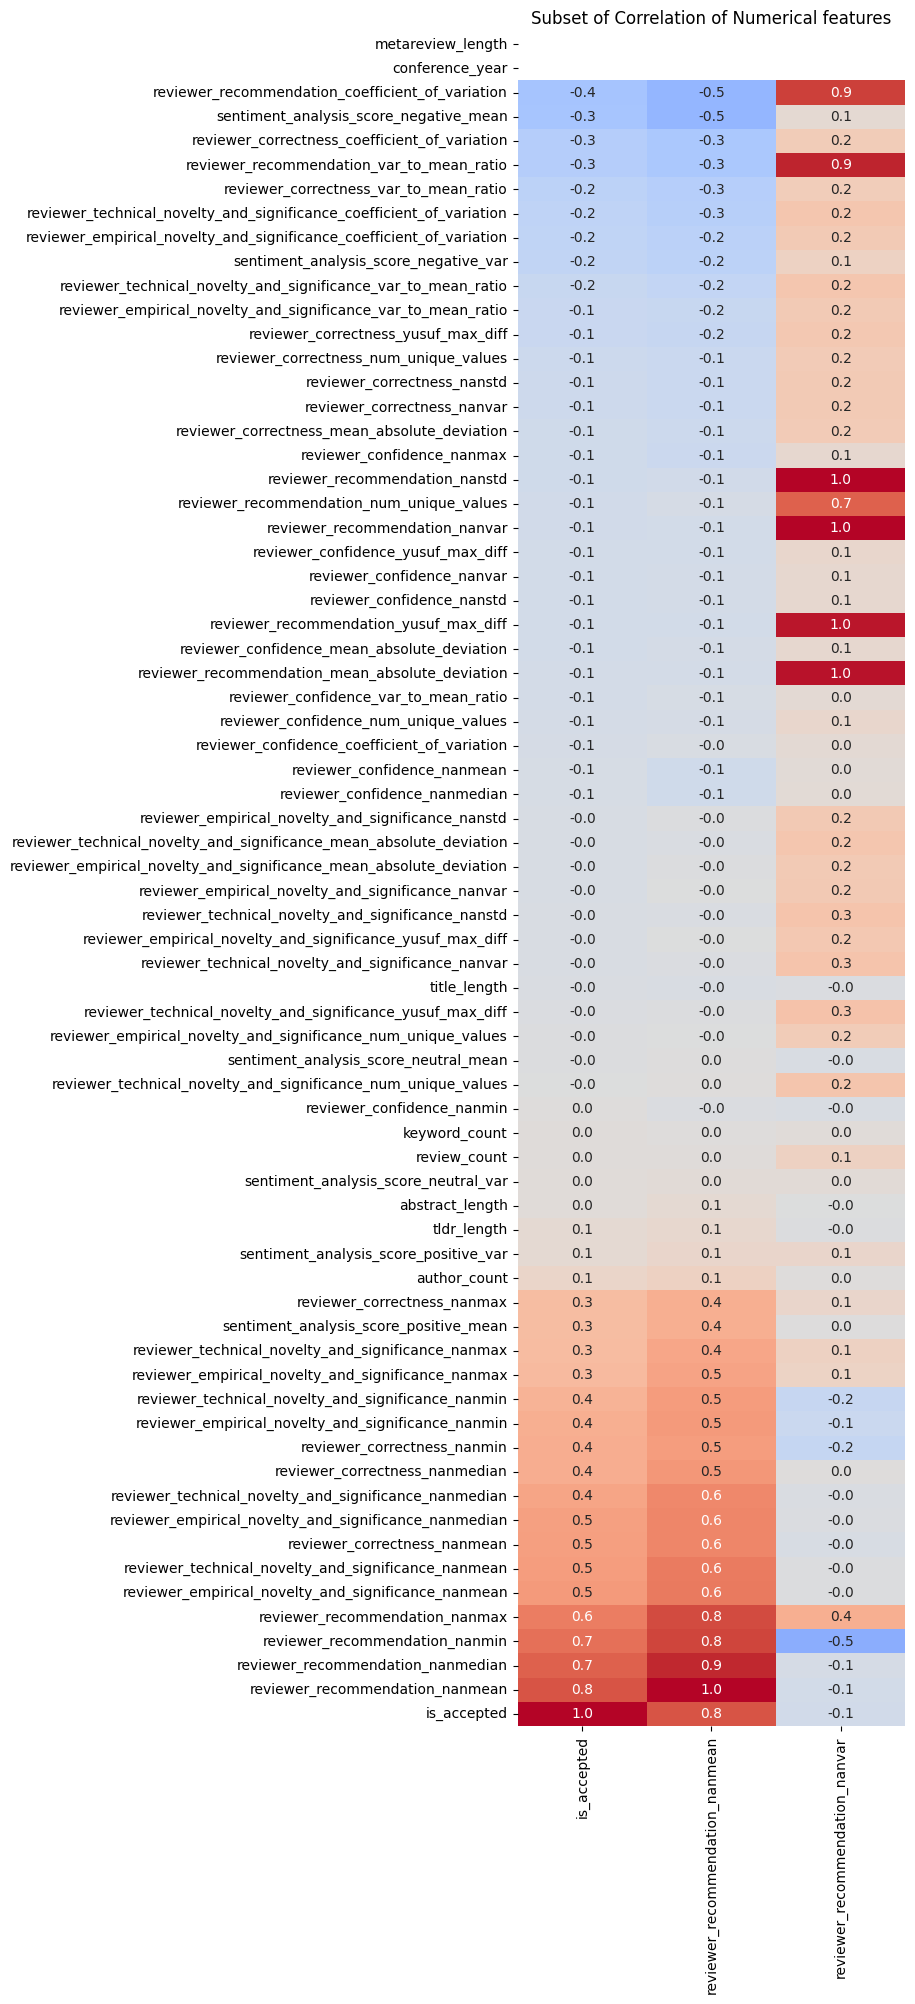

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


cols = ['is_accepted',
    'reviewer_recommendation_nanmean',
    'reviewer_recommendation_nanvar',]

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(5, 22))  # Adjust the figure size for better visibility
ax = sns.heatmap(sorted_corr_matrix[cols], annot=True, fmt='.1f', cmap='coolwarm', cbar=False, center=0, vmin=-1, vmax=1)

# Flip the y-axis to have reviewer_confidence_nanvar at the top
ax.invert_yaxis()

plt.title("Subset of Correlation of Numerical features")
plt.show()